In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import community
import matplotlib.pyplot as plt

from pyod.models.cblof import CBLOF
from sklearn.preprocessing import LabelEncoder

In [2]:
data_folder = '/home/sunilkarki/Documents/Persn/CProj/bnp/data'

file_path = os.path.join(data_folder, 'transactions1.csv')
blockchain_data = pd.read_csv(file_path)

In [3]:

# Convert hex values to label encoded numeric values
label_encoder = LabelEncoder()

blockchain_data['From'] = label_encoder.fit_transform(blockchain_data['From'])
blockchain_data['To'] = label_encoder.fit_transform(blockchain_data['To'])

blockchain_data['Value (ETH)'] = pd.to_numeric(blockchain_data['Value (ETH)'], errors='coerce')
# blockchain_data['Value (ETH)'] = blockchain_data['Value (ETH)'].div(1000000000000000000).round(4)
blockchain_data['Value (ETH)'] = (blockchain_data['Value (ETH)'] / 1000000000000000000).round(4)

# Select relevant columns for the analysis
selected_columns = ['From', 'To', 'Value (ETH)']
selected_data = blockchain_data[selected_columns]

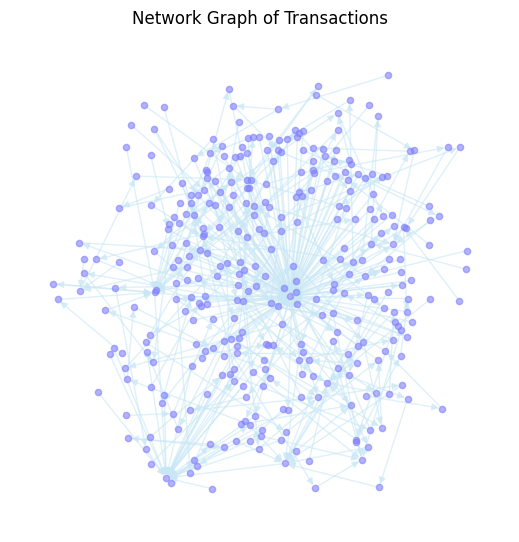

In [12]:
G1 = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', create_using=nx.DiGraph())

# Draw the network graph
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G1, k=0.11, iterations=12)
nx.draw(G1, pos, node_size=20, alpha=0.6, edge_color='#C8E7F5', node_color='#7f7fff', with_labels=False)
plt.title('Network Graph of Transactions')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


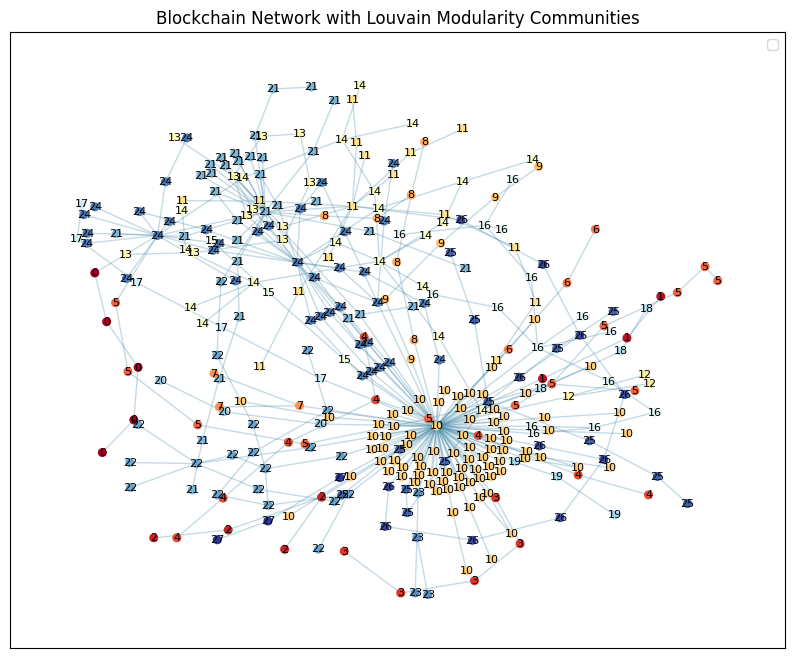

In [126]:

# Create a directed graph from the blockchain data
G = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', ['Value (ETH)'], create_using=nx.Graph())

# Louvain Modularity for Community Detection
partition = community.best_partition(G)

# Add the community information to the blockchain data
blockchain_data['Community'] = blockchain_data['From'].map(partition)

# Visualize the network graph with communities and PageRank scores
pos = nx.spring_layout(G, seed=5, k=0.15)
plt.figure(figsize=(10, 8))

# Draw nodes colored by community
nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
# nx.draw_networkx_edges(G, pos, width=1, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, edge_color='#3f86a6')
# nx.draw_networkx_edges(G, pos, width=1, ax=ax)

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=8)

plt.title("Blockchain Network with Louvain Modularity Communities")
plt.legend()
plt.show()


In [127]:
blockchain_data.head

<bound method NDFrame.head of      Block Number                                   Transaction Hash  From  \
0        17140930  0xa7af6f90a8cd6a7d5279a050af0f43061194632d9021...   118   
1        17140930  0xcc784b110da9733eff91a98317c69120a90895ee8f5e...   251   
2        17140930  0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...   306   
3        17140930  0x3d5753ff616de541fd04be5b9d1394cae7f498b20ee6...   132   
4        17140930  0x2bcbbdecb2a8728a840cbe30d11373cc816dc9e7030c...   156   
..            ...                                                ...   ...   
370      17140932  0x3a5957252f76bc7bd3b7d5edf120615a9168841eb89d...   325   
371      17140932  0x20b17015288c93cc5b0d8064ed3e68aac56ad1abcfc5...   127   
372      17140932  0xb519e60a7e8c89a0d6c2cabe644d026d7a7654945699...   279   
373      17140932  0xe7d1708b6aa09d3d41ab2c5c7838515995113684a429...   146   
374      17140932  0x755bf092b8b5e1be59f52735ae2340a08e633b2bdc03...    38   

      To  Value (ETH)            

In [128]:

# CBLOF for Anomaly Detection
X = selected_data.values

# Normalize the 'Value (ETH)' column to ensure a consistent scale for CBLOF
# X[:, -1] = (X[:, -1] - X[:, -1].min()) / (X[:, -1].max() - X[:, -1].min())

# Train CBLOF model
cblof_model = CBLOF()
cblof_model.fit(X)

# Predict outliers
outliers = cblof_model.predict(X)


# # Get anomaly scores using decision_function
# anomaly_scores = cblof_model.decision_function(X)

# # Set a threshold
# threshold = 0.8

# # Predict outliers based on the threshold
# outliers = (anomaly_scores > threshold).astype(int)


# Add anomaly information to the blockchain data
blockchain_data['Anomaly'] = outliers

# Display the blockchain data with community and anomaly information
blockchain_data

/home/sunilkarki/Documents/Persn/CProj/bnp/virtualenvs/.py3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly
0,17140930,0xa7af6f90a8cd6a7d5279a050af0f43061194632d9021...,118,83,0.1500,2023-04-28 05:45:23,24,0
1,17140930,0xcc784b110da9733eff91a98317c69120a90895ee8f5e...,251,86,0.2500,2023-04-28 05:45:23,1,1
2,17140930,0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...,306,140,1.4924,2023-04-28 05:45:23,2,0
3,17140930,0x3d5753ff616de541fd04be5b9d1394cae7f498b20ee6...,132,62,0.0421,2023-04-28 05:45:23,3,0
4,17140930,0x2bcbbdecb2a8728a840cbe30d11373cc816dc9e7030c...,156,16,1.3592,2023-04-28 05:45:23,4,0
...,...,...,...,...,...,...,...,...
370,17140932,0x3a5957252f76bc7bd3b7d5edf120615a9168841eb89d...,325,169,0.0350,2023-04-28 05:45:47,17,0
371,17140932,0x20b17015288c93cc5b0d8064ed3e68aac56ad1abcfc5...,127,147,2.3984,2023-04-28 05:45:47,24,1
372,17140932,0xb519e60a7e8c89a0d6c2cabe644d026d7a7654945699...,279,102,0.0078,2023-04-28 05:45:47,5,0
373,17140932,0xe7d1708b6aa09d3d41ab2c5c7838515995113684a429...,146,160,0.4000,2023-04-28 05:45:47,13,1


In [129]:
# Finding anomalies by CBLOF

anomaly_data_by_cblof = blockchain_data[blockchain_data['Anomaly'] != 0]

# Display the filtered data
anomaly_data_by_cblof

,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly
1,17140930,0xcc784b110da9733eff91a98317c69120a90895ee8f5e...,251,86,0.2500,2023-04-28 05:45:23,1,1
16,17140930,0xdceee6db33d7d351f06b15bb8a8e848693634706553f...,9,98,0.7651,2023-04-28 05:45:23,11,1
36,17140930,0xd19ff5229107019c63fc89665b8d0b7b5dbd4c1debbd...,245,80,30.9761,2023-04-28 05:45:23,10,1
48,17140930,0xe3d72f1d4e8ad54c987e9c3907a664cd45d760e41f85...,133,101,1.0963,2023-04-28 05:45:23,21,1
49,17140930,0x1c4f60189bb40dc4830272bab212cd453a6c64c42aa8...,154,164,0.0008,2023-04-28 05:45:23,24,1
106,17140930,0xa81ae8fe78bb64fdfed3e37f32605e6011c168cf4823...,112,150,5.4869,2023-04-28 05:45:23,24,1
155,17140930,0x009bd67baac24154fa92112053d771a551ed03781562...,201,154,0.0150,2023-04-28 05:45:23,24,1
164,17140930,0x496fb651c8d211d7270f617fcceb4f142d82033350e9...,201,148,0.0150,2023-04-28 05:45:23,24,1
168,17140930,0x37e58c1e7a4a1a3320251df904ee70a3b15a2f24f23c...,215,170,0.1300,2023-04-28 05:45:23,11,1
180,17140930,0x6de7f828ca1365dc68840d8763baa076ba210f00c777...,141,30,78.3329,2023-04-28 05:45:23,6,1


In [130]:
# No. of anomalies found by CBLOF 304 in 2696
anomaly_data_by_cblof.size

304

In [131]:
# Finding anomalies by Page Rank

pagerank_scores = nx.pagerank(G)

# Add PageRank scores to the blockchain data
blockchain_data['PageRank'] = blockchain_data['From'].map(pagerank_scores)

# Identify anomalies based on PageRank scores
# You can set a threshold for PageRank scores to determine anomalies
threshold = 0.01
anomaly_data_by_pagerank = blockchain_data[blockchain_data['PageRank'] > threshold]

anomaly_data_by_pagerank

,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly,PageRank
42,17140930,0xf373256eeeaba2eac8e8a396f385bbb0a7231e2b4a41...,30,166,0.0040,2023-04-28 05:45:23,10,0,0.128991
104,17140930,0xe68fa4a555e2907457448768a34ce4f7a1ce2b0ed92a...,201,104,0.0150,2023-04-28 05:45:23,24,0,0.020067
155,17140930,0x009bd67baac24154fa92112053d771a551ed03781562...,201,154,0.0150,2023-04-28 05:45:23,24,1,0.020067
156,17140930,0x2768d1dc72eb91c1507114aa9275c3a8b12db68ca0c0...,201,115,0.0150,2023-04-28 05:45:23,24,0,0.020067
159,17140930,0xdc0f088a2a1ae1f8479227154d5e6b5bea1cc9b677be...,201,93,0.0150,2023-04-28 05:45:23,24,0,0.020067
161,17140930,0x6c4460859ee627d3b03f2a3cf5b176f4c40916926c5d...,201,117,0.0150,2023-04-28 05:45:23,24,0,0.020067
162,17140930,0xa80885be4ff973dde27d85ddabe22dc49f654292d59f...,201,119,0.0150,2023-04-28 05:45:23,24,0,0.020067
164,17140930,0x496fb651c8d211d7270f617fcceb4f142d82033350e9...,201,148,0.0150,2023-04-28 05:45:23,24,1,0.020067
167,17140930,0x452d4c321286b19e11a1f15c45c6534118abb3e0989f...,201,69,0.0150,2023-04-28 05:45:23,24,0,0.020067
169,17140930,0xb8e5a483d19a59476cae2e147334993e92bd444add44...,201,118,0.0150,2023-04-28 05:45:23,24,0,0.020067


In [132]:
G = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', ['Value (ETH)'], create_using=nx.DiGraph())

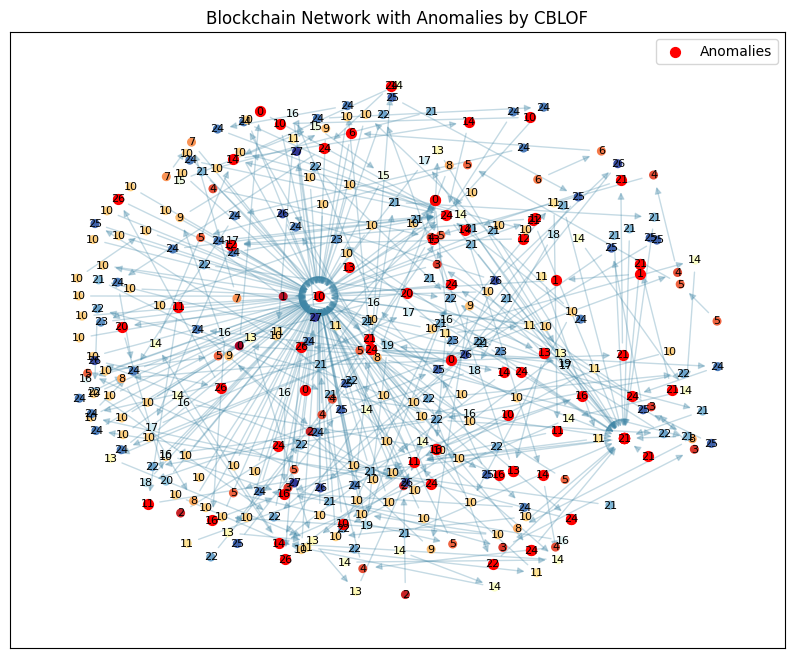

In [133]:
# CBLOF


# Visualize the network graph with communities
# pos = nx.spring_layout(G, seed=5, k=0.15)
pos = nx.spring_layout(G, seed=5, k=0.4)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='#3f86a6')

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=8)

# Highlight anomalies with a different color or marker
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=anomaly_data_by_cblof['From'].tolist() + anomaly_data_by_cblof['To'].tolist(),
    node_size=50,
    node_color='red',
    label='Anomalies'
)

plt.title("Blockchain Network with Anomalies by CBLOF")
plt.legend()
plt.show()

In [134]:
G = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', ['Value (ETH)'], create_using=nx.DiGraph())

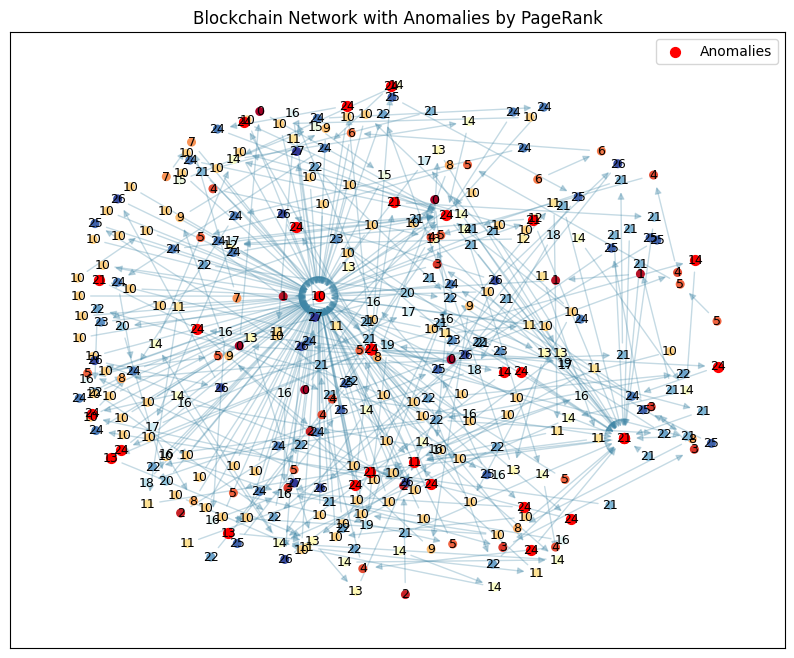

In [135]:
# PageRank


# Visualize the network graph with communities
pos = nx.spring_layout(G, seed=5, k=0.4)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='#3f86a6')

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=9)

# Highlight anomalies with a different color or marker
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=anomaly_data_by_pagerank['From'].tolist() + anomaly_data_by_pagerank['To'].tolist(),
    node_size=50,
    node_color='red',
    label='Anomalies'
)

plt.title("Blockchain Network with Anomalies by PageRank")
plt.legend()
plt.show()